# Evaluation
Submissions are evaluated one the Root Mean Squared Logarithmic Error (RMSLE).

분류와 회귀중 회귀와 관련 된 문제 => 자전거 대여량을 예측하는 문제이기 때문

### 라이브러리 불러오기 및 한글 폰트 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
# 구글코랩 사용시 폰트 설정 필요
# 한글폰트를 설정해주지 않으면 그래프 상에서 한글이 깨져보임
# 한글 출력 가능하게 폰트설정
# 설치 후 런타임 재실행 필수!
# 나눔고딕 설치 (이 코드 사용 시 아래있는 폰트 로드할 경우 colab에서 오류발생 아래의 폰트 설정 꼭 주석처리!)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# Colab의 한글폰트 설정
plt.rc('font', family = 'NanumGothic')
# 마이너스 폰트 깨지는 문제에 대한 대처
plt.rc("axes", unicode_minus = False)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [3]:
# 레티나 설정 시 글씨가 좀 더 선명히 보임
# 폰트의 주변이 흐릿하게 보이는 것을 방지
%config InlineBackend.figure_format = 'retina'

# 데이터 분석 시작

In [4]:
#구글 드라이브 연동하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA/자전거 수요예측/train.csv', parse_dates=["datetime"])
train.shape

(10886, 12)

In [6]:
# 컬럼 명 확인
# train.columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [7]:
# 데이터 확인
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

In [9]:
# 결측치 확인
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

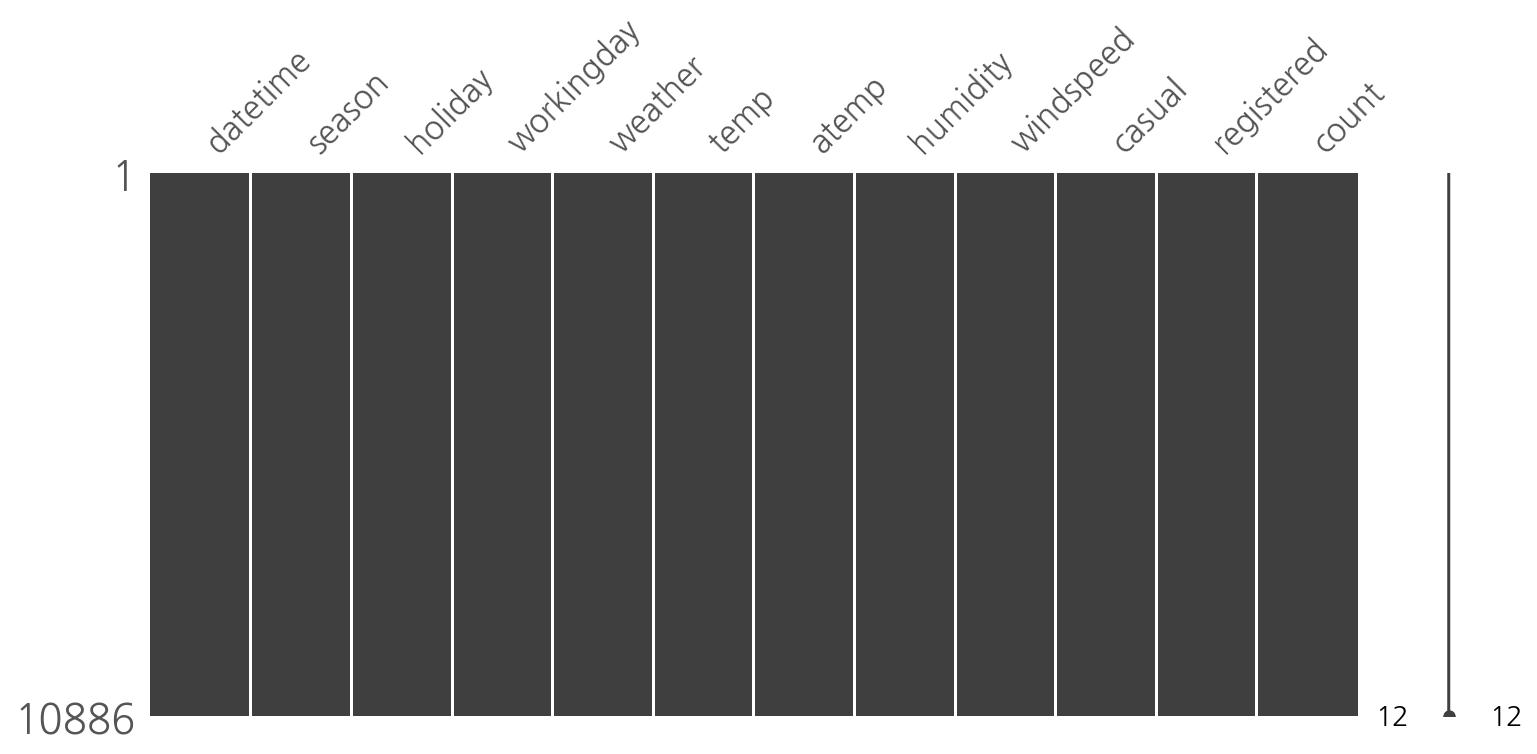

In [10]:
# 결측치 유무 시각화
import missingno as msno

msno.matrix(train, figsize = (12,5))

In [11]:
# 시각화가 편하도록 시간에 따라 데이터 나누기 (년/월/일/시/분/초)
train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["day"] = train["datetime"].dt.day
train["hour"] = train["datetime"].dt.hour
train["minute"] = train["datetime"].dt.minute
train["second"] = train["datetime"].dt.second

train.shape

(10886, 18)

In [12]:
# 데이터 재확인
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


[Text(0.5, 0, 'hour'), Text(0.5, 1.0, '시간별 대여량')]

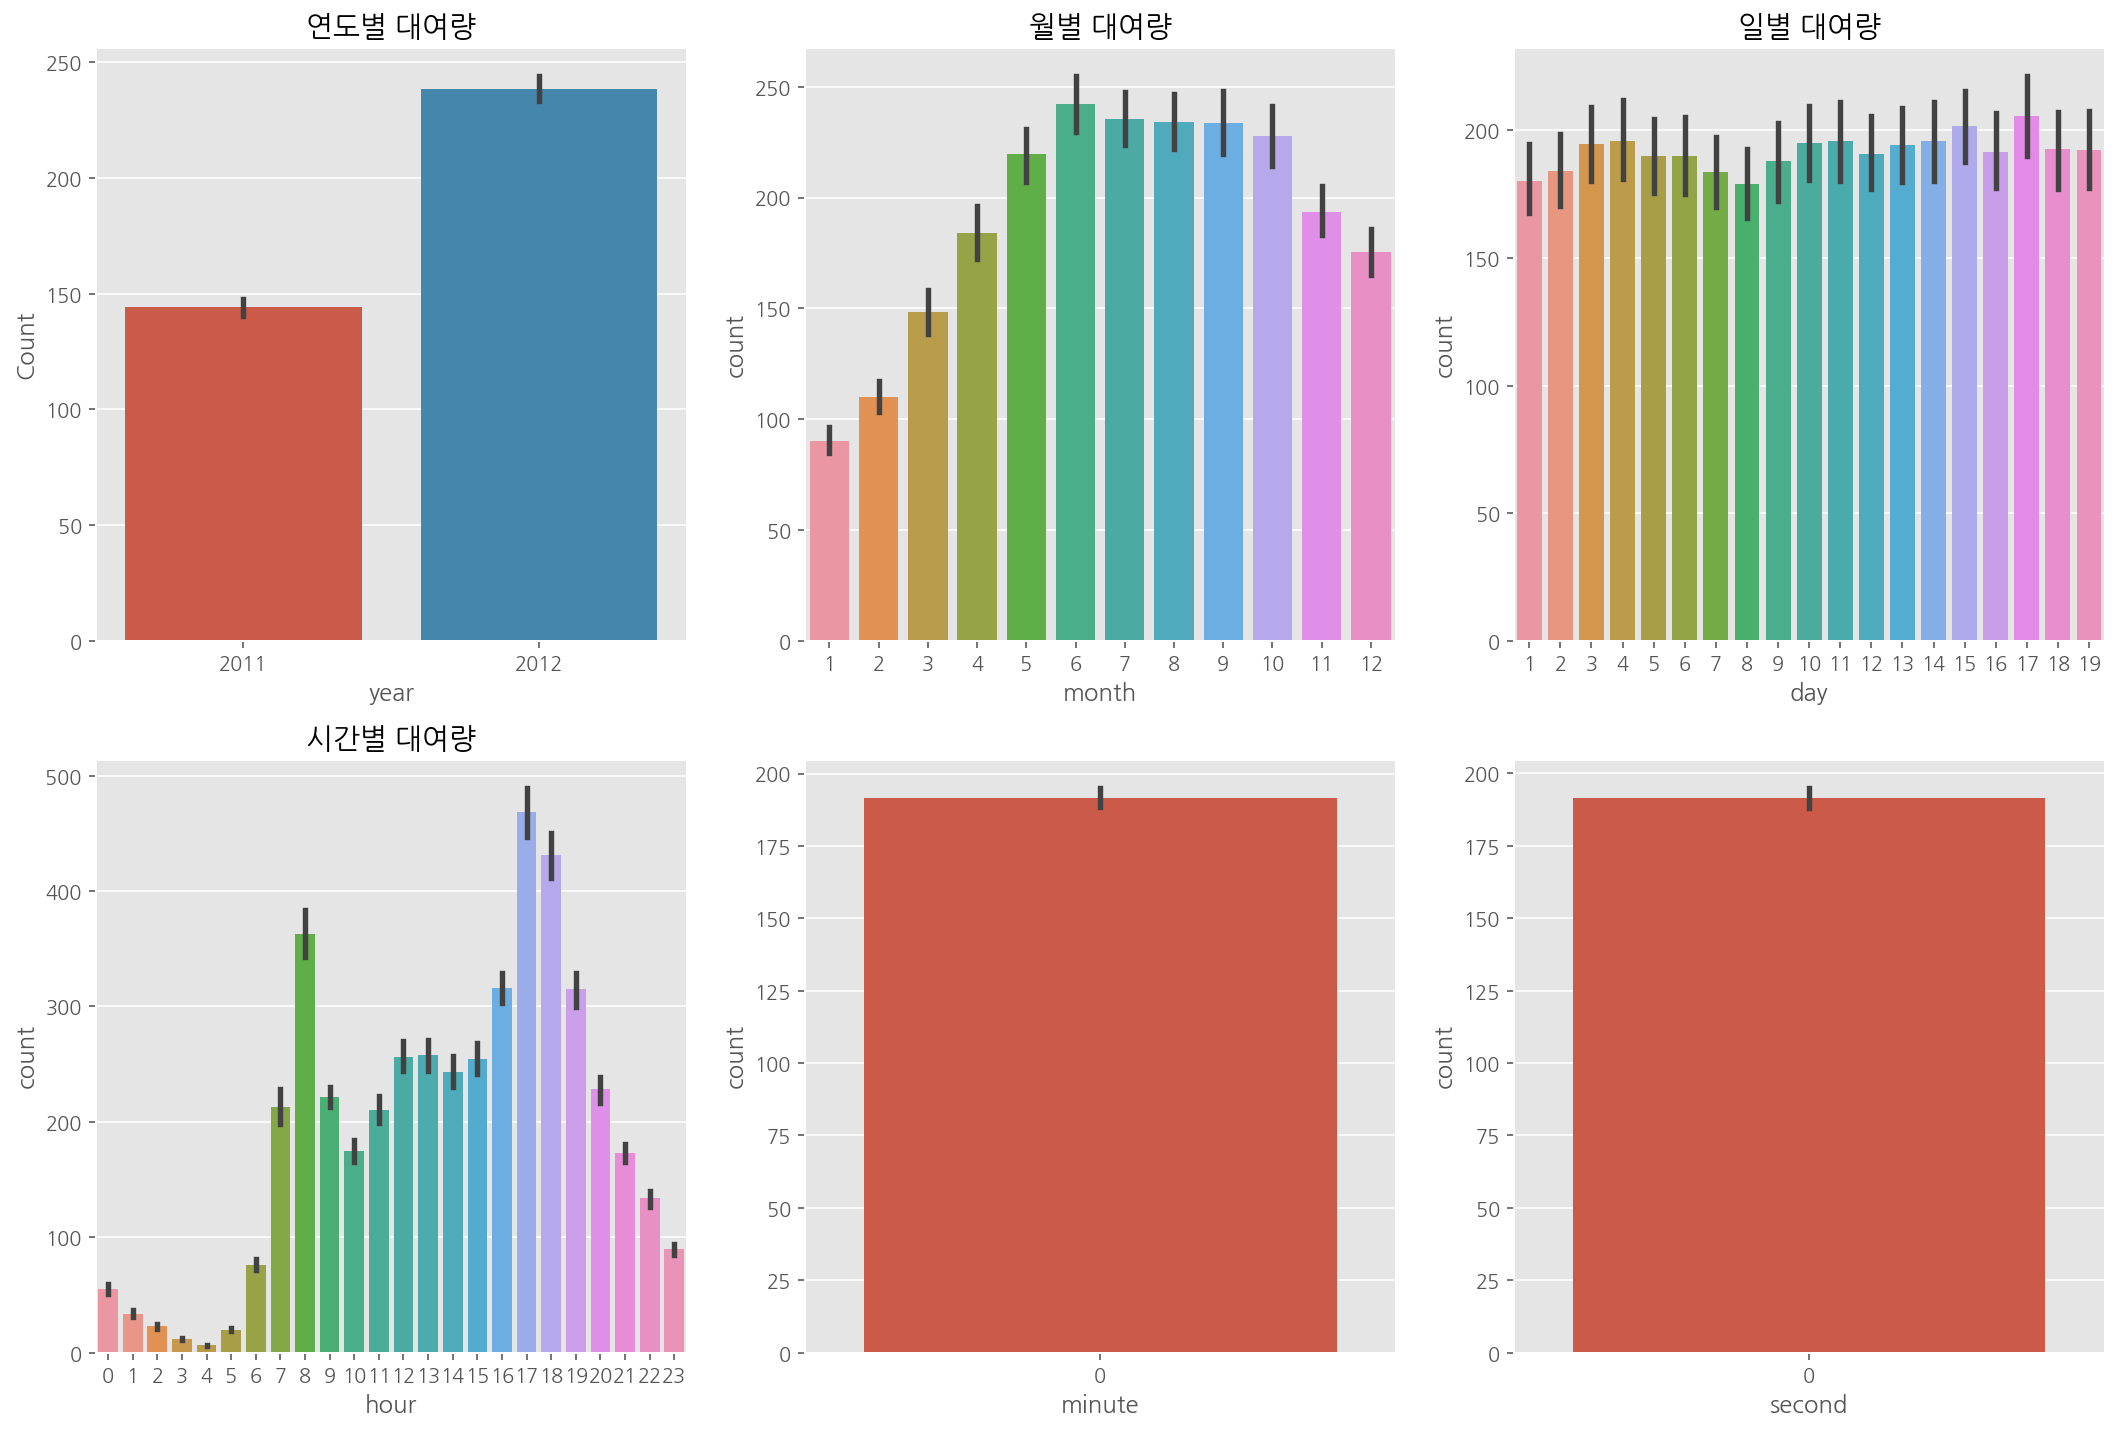

In [13]:
figure, ((ax1,ax2,ax3), (ax4,ax5,ax6)) = plt.subplots(nrows=2, ncols=3)
figure.set_size_inches(18,12)

sns.barplot(data=train, x="year", y="count", ax=ax1)
sns.barplot(data=train, x="month", y="count", ax=ax2)
sns.barplot(data=train, x="day", y="count", ax=ax3)
sns.barplot(data=train, x="hour", y="count", ax=ax4)
sns.barplot(data=train, x="minute", y="count", ax=ax5)
sns.barplot(data=train, x="second", y="count", ax=ax6)

ax1.set(ylabel='Count',title="연도별 대여량")
ax2.set(xlabel='month',title="월별 대여량")
ax3.set(xlabel='day', title="일별 대여량")
ax4.set(xlabel='hour', title="시간별 대여량")

* 연도별 대여량이 2011 < 2012
* 월별 대여량은 6월이 가장 많고, 7~10월도 대여량이 많으며 1월이 가장 적음 (날이 추울 때 보다는 더울 때 많이 이용)
* 일별 대여량은 1~19일만 존재, 나머지는 test.csv파일에 있어 피처로 사용 불가
* 시간 대 대여량 확인 시 출퇴근 시간에 대여량이 높음.(주말과 나눠볼 필요 존재)
* 분, 초도 다 0이기 때문에 의미 없음

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, '근무일 여부에 따른 대여량')]

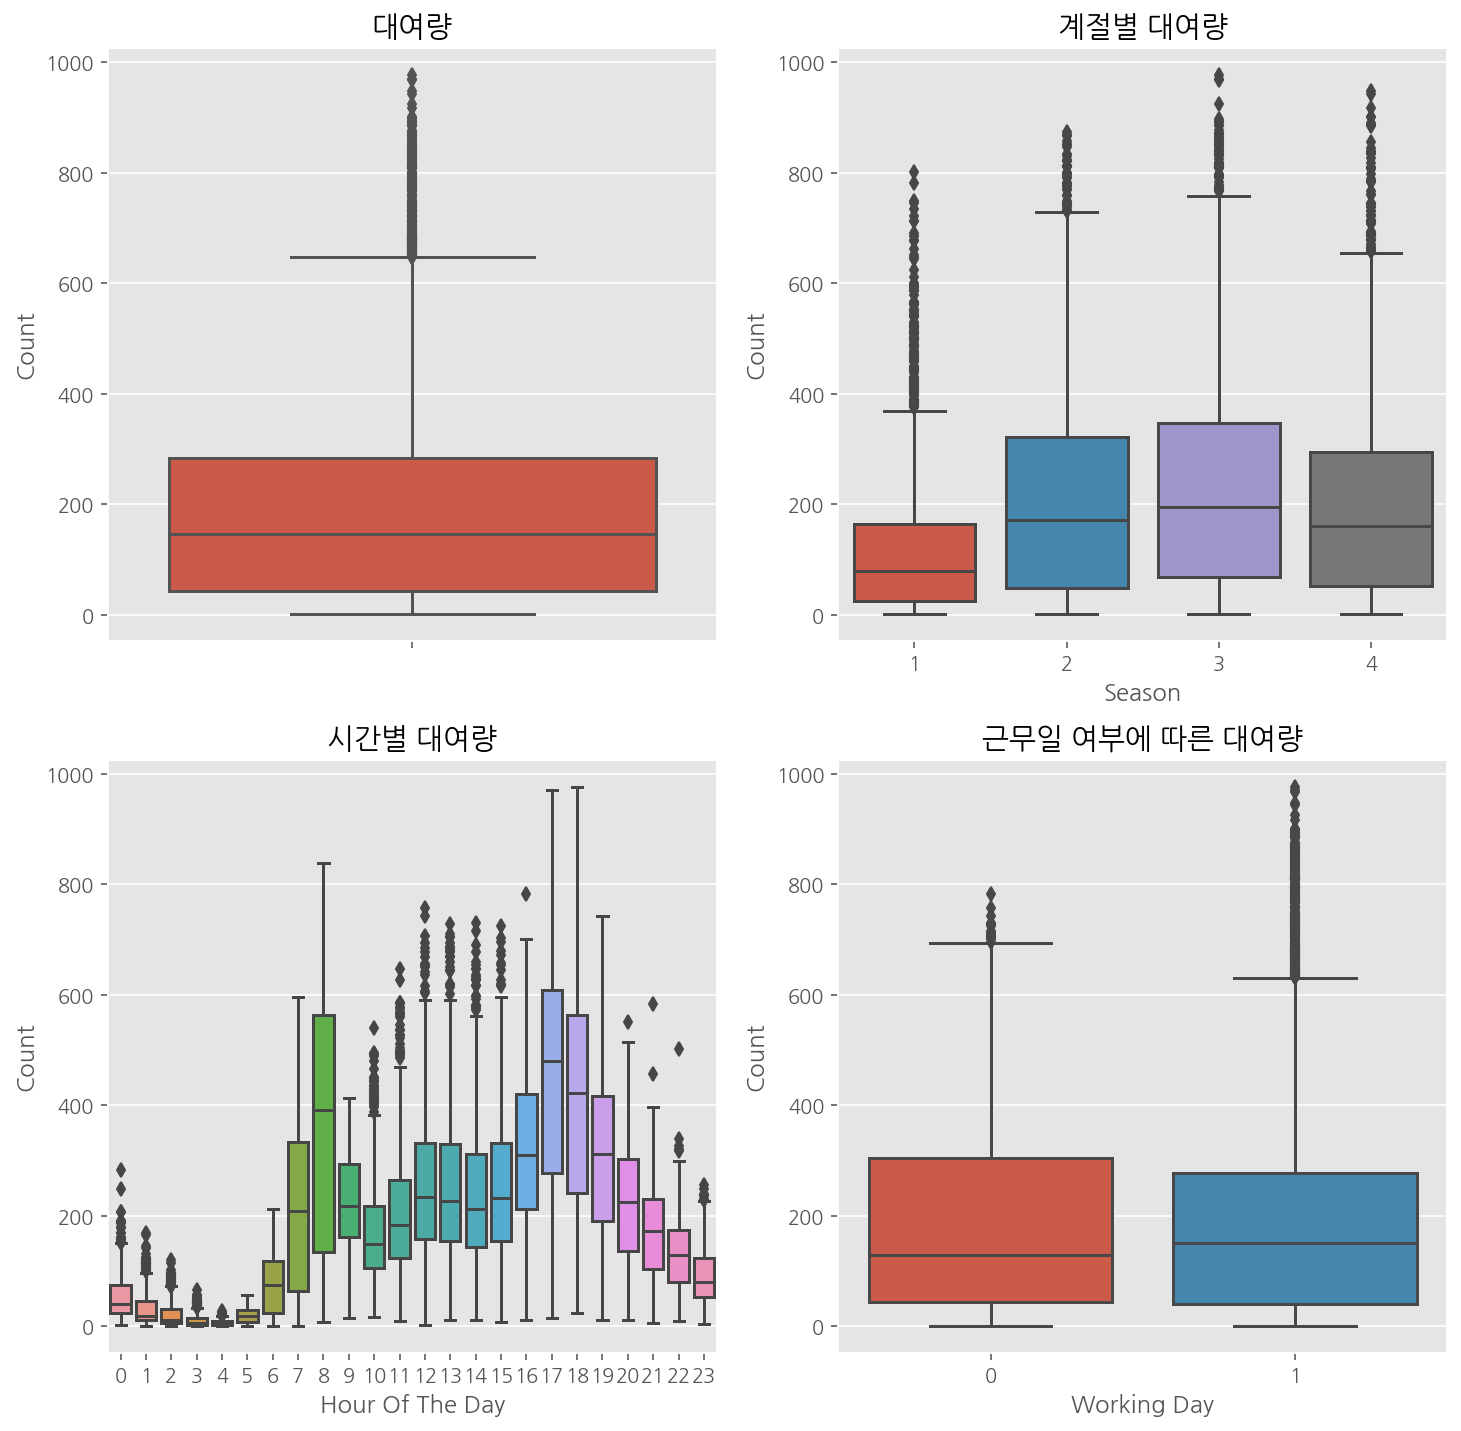

In [14]:
# 계절별, 시간별, 근무 여부에 따라 나눠서 시각화
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 12)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="대여량")
axes[0][1].set(xlabel='Season', ylabel='Count',title="계절별 대여량")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="시간별 대여량")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="근무일 여부에 따른 대여량")

In [15]:
# dayofweek 데이터를 데이터 프레임에 담기(요일별)
train["dayofweek"] = train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [16]:
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

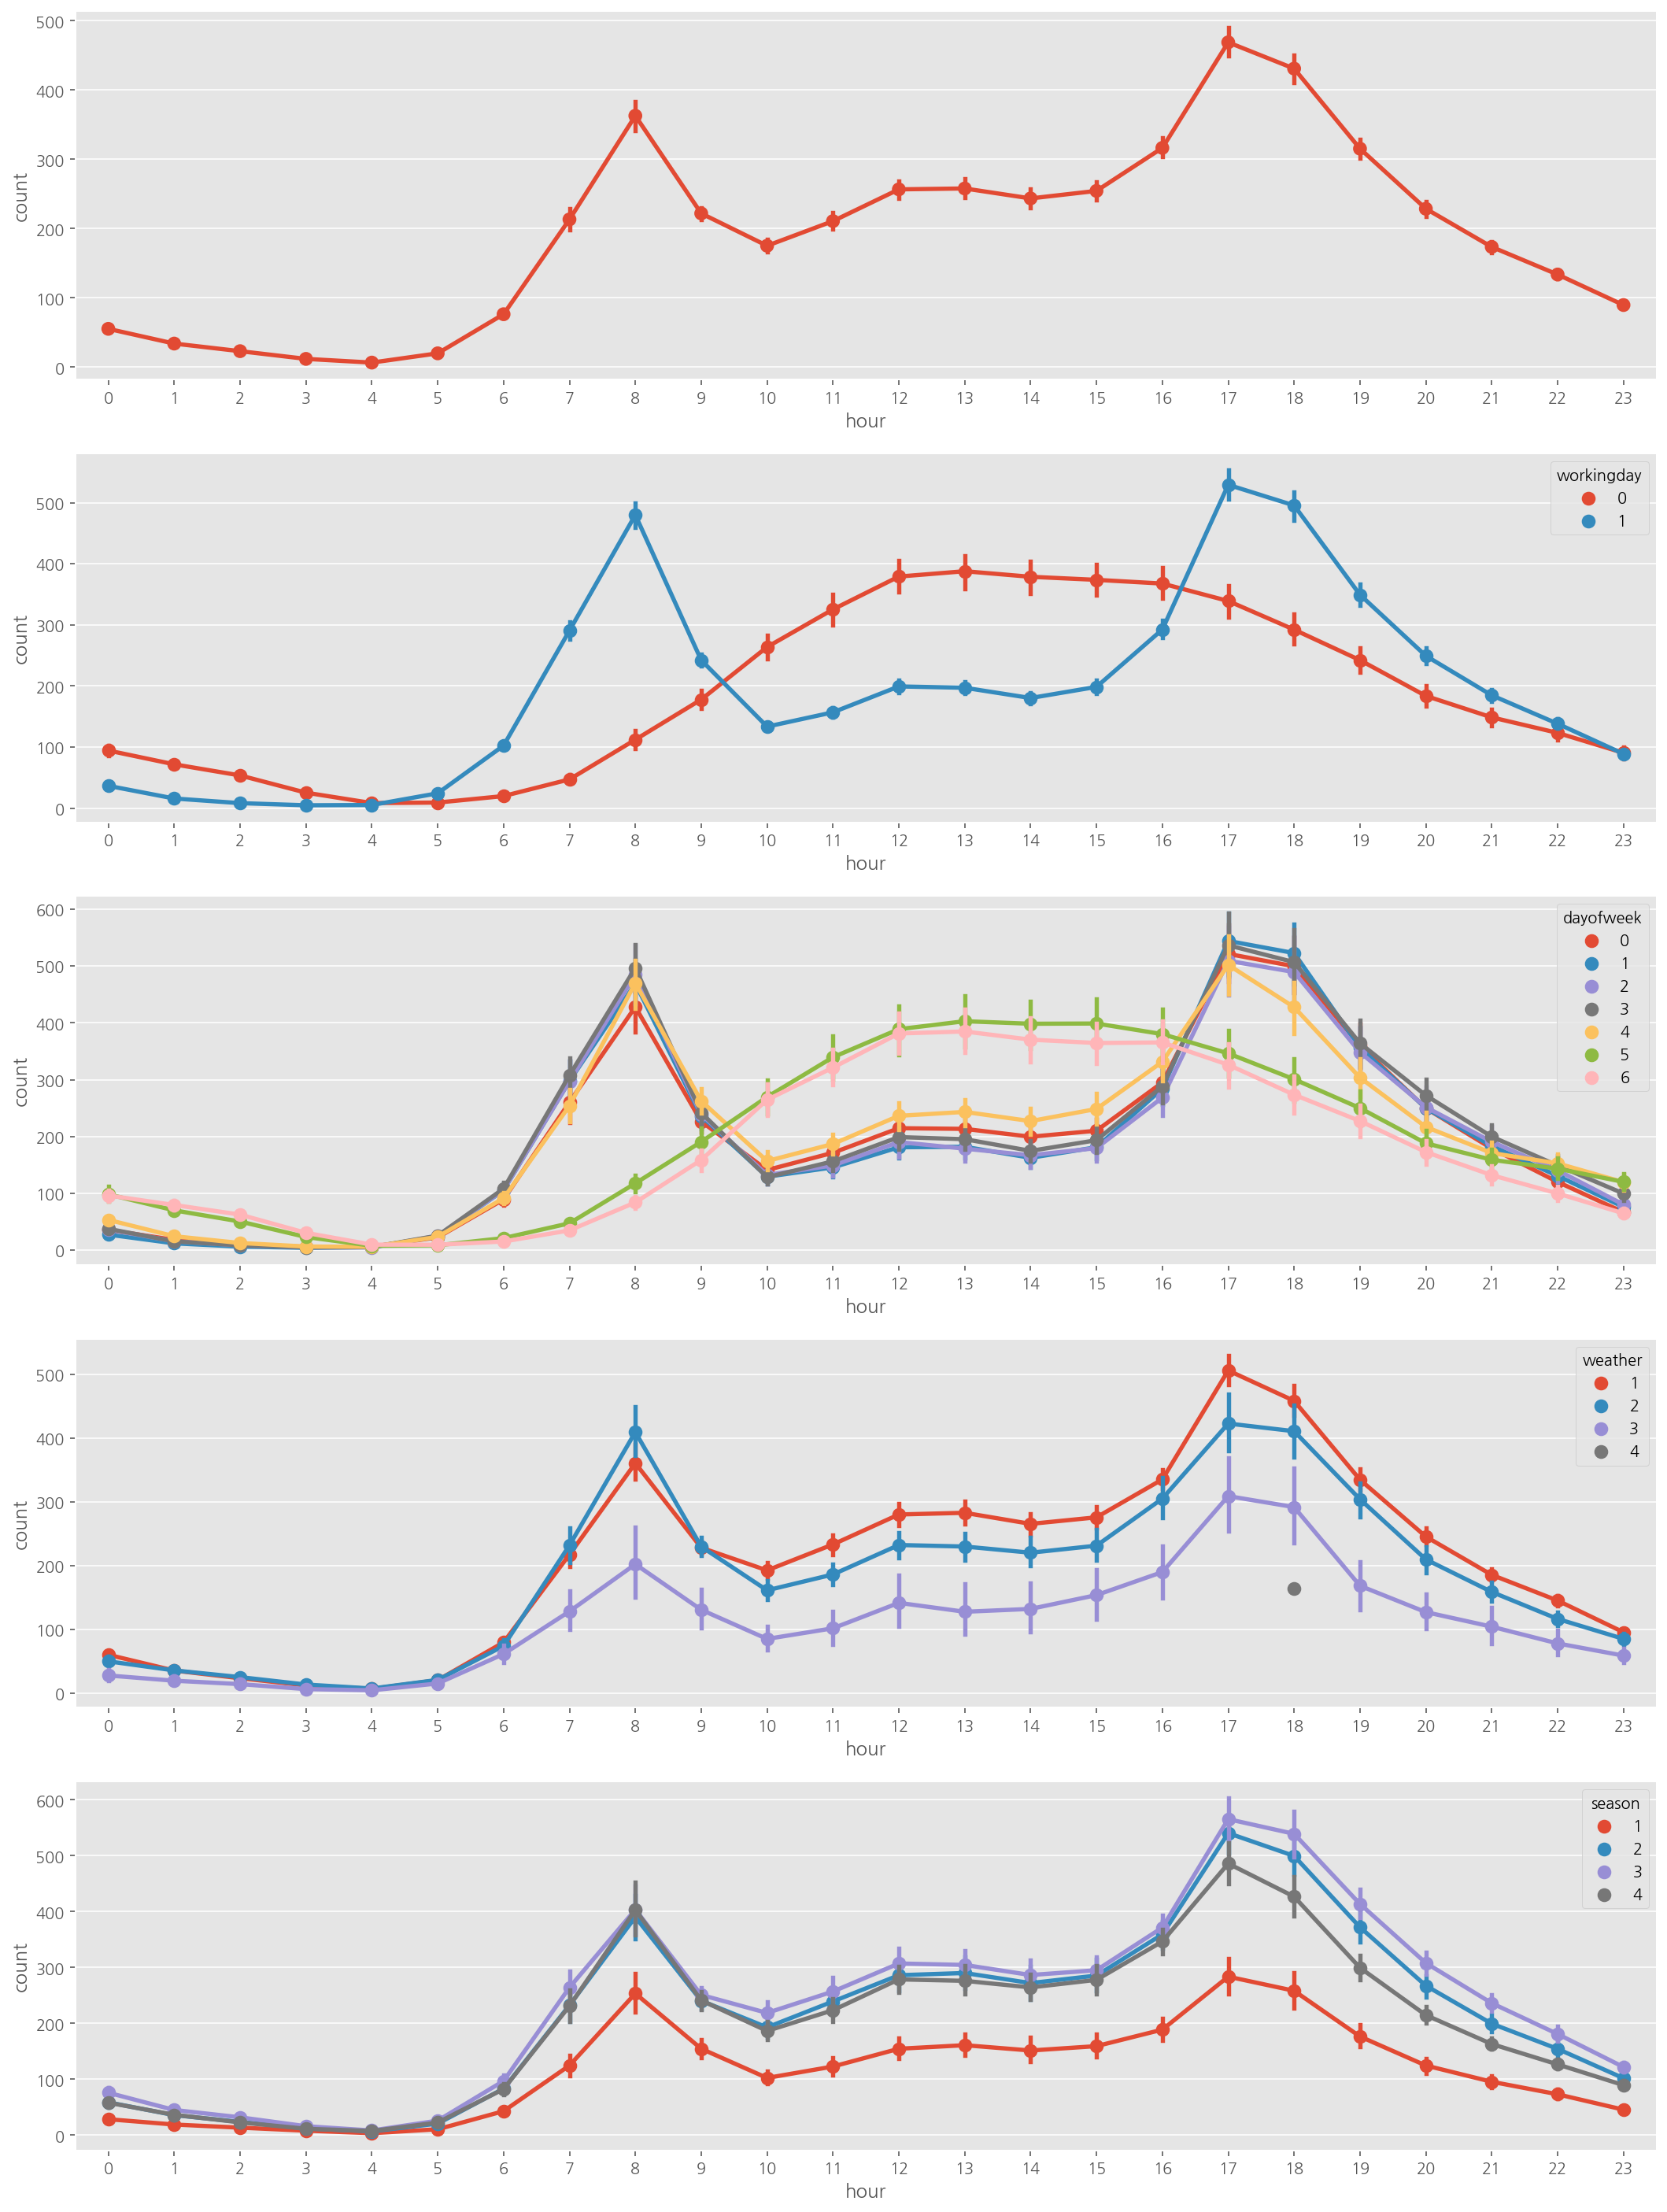

In [17]:
fig,(ax1,ax2,ax3,ax4,ax5)= plt.subplots(nrows=5) # 5개의 그래프 확인
fig.set_size_inches(18,25)

# 시간대 별 그래프
sns.pointplot(data=train, x="hour", y="count", ax=ax1)
sns.pointplot(data=train, x="hour", y="count", hue="workingday", ax=ax2)
sns.pointplot(data=train, x="hour", y="count", hue="dayofweek", ax=ax3)
sns.pointplot(data=train, x="hour", y="count", hue="weather", ax=ax4)
sns.pointplot(data=train, x="hour", y="count", hue="season", ax=ax5)

In [18]:
# 온도, 습도, 풍속 등의 연관관계를 히트맵으로 표현
corrMatt = train[["temp", "atemp", "casual", "registered", "humidity", "windspeed", "count"]]
corrMatt = corrMatt.corr()
print(corrMatt)

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

                temp     atemp    casual  ...  humidity  windspeed     count
temp        1.000000  0.984948  0.467097  ... -0.064949  -0.017852  0.394454
atemp       0.984948  1.000000  0.462067  ... -0.043536  -0.057473  0.389784
casual      0.467097  0.462067  1.000000  ... -0.348187   0.092276  0.690414
registered  0.318571  0.314635  0.497250  ... -0.265458   0.091052  0.970948
humidity   -0.064949 -0.043536 -0.348187  ...  1.000000  -0.318607 -0.317371
windspeed  -0.017852 -0.057473  0.092276  ... -0.318607   1.000000  0.101369
count       0.394454  0.389784  0.690414  ... -0.317371   0.101369  1.000000

[7 rows x 7 columns]


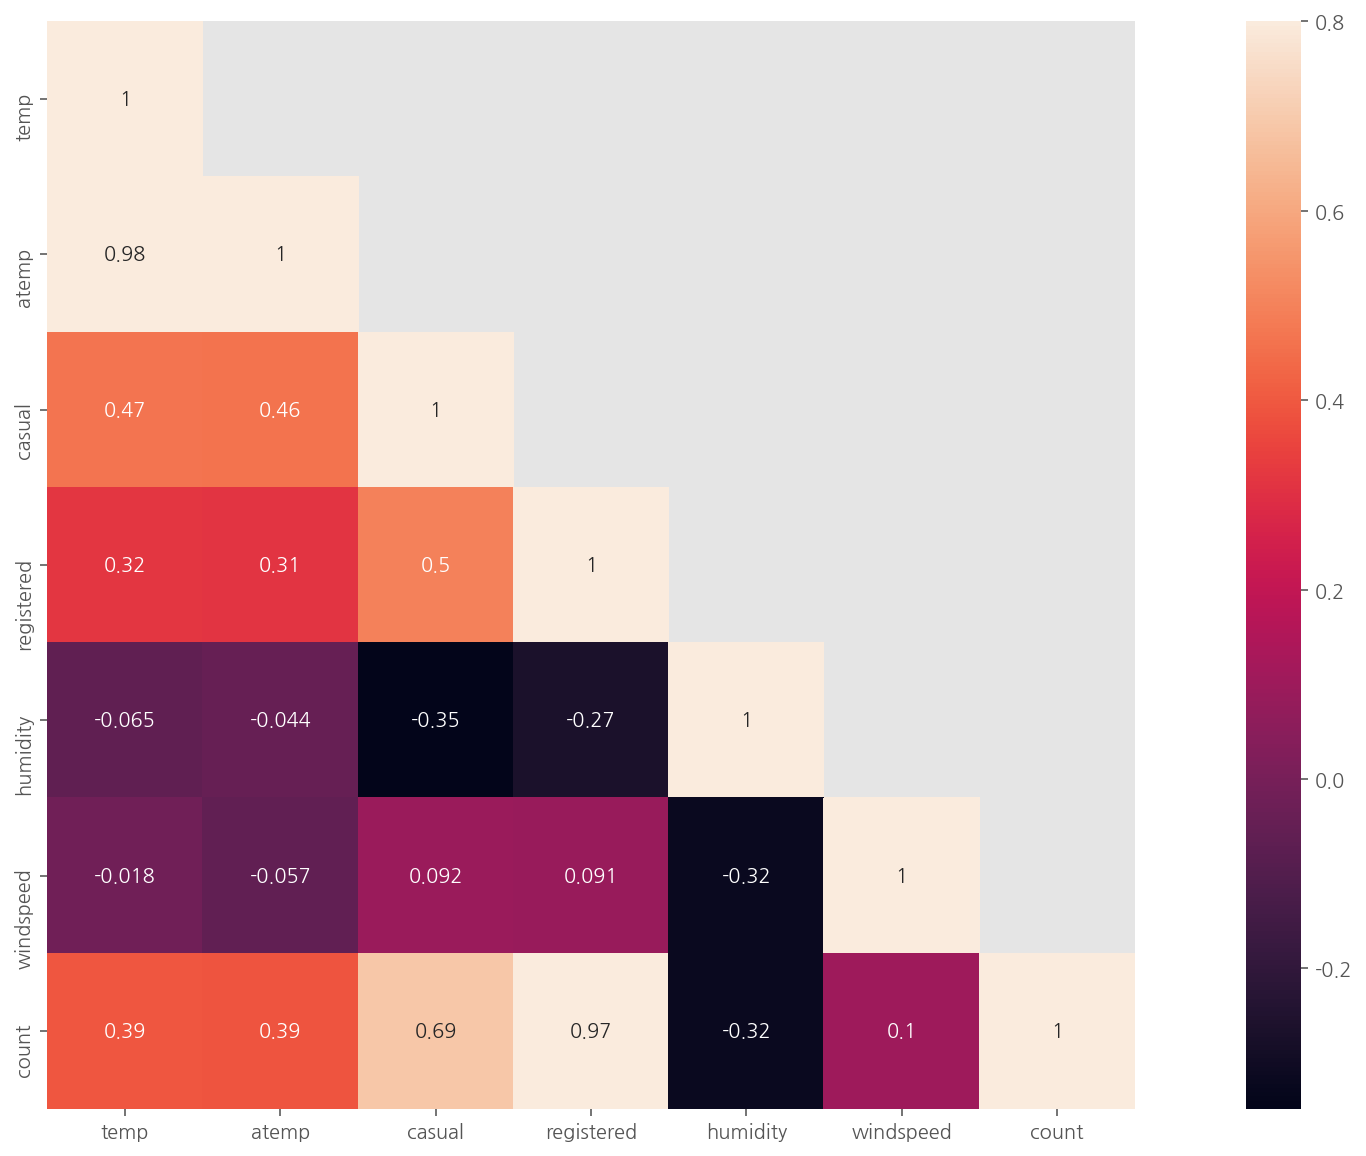

In [19]:
# 히트맵 시각화
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask,vmax=.8, square=True,annot=True)

* 온도, 습도, 풍속은 거의 연관이 없음
* 대여량과 가장 연관이 높은 것은 registered 로 등록 된 대여자가 많지만, test 데이터에는 이 값이 없다. (피처로 사용 적합치 못함)
* atemp와 temp는 0.98로 상관관계가 높지만 온도와 체감온도로 피처로 사용하기에 적합하지 않을 수 있다.

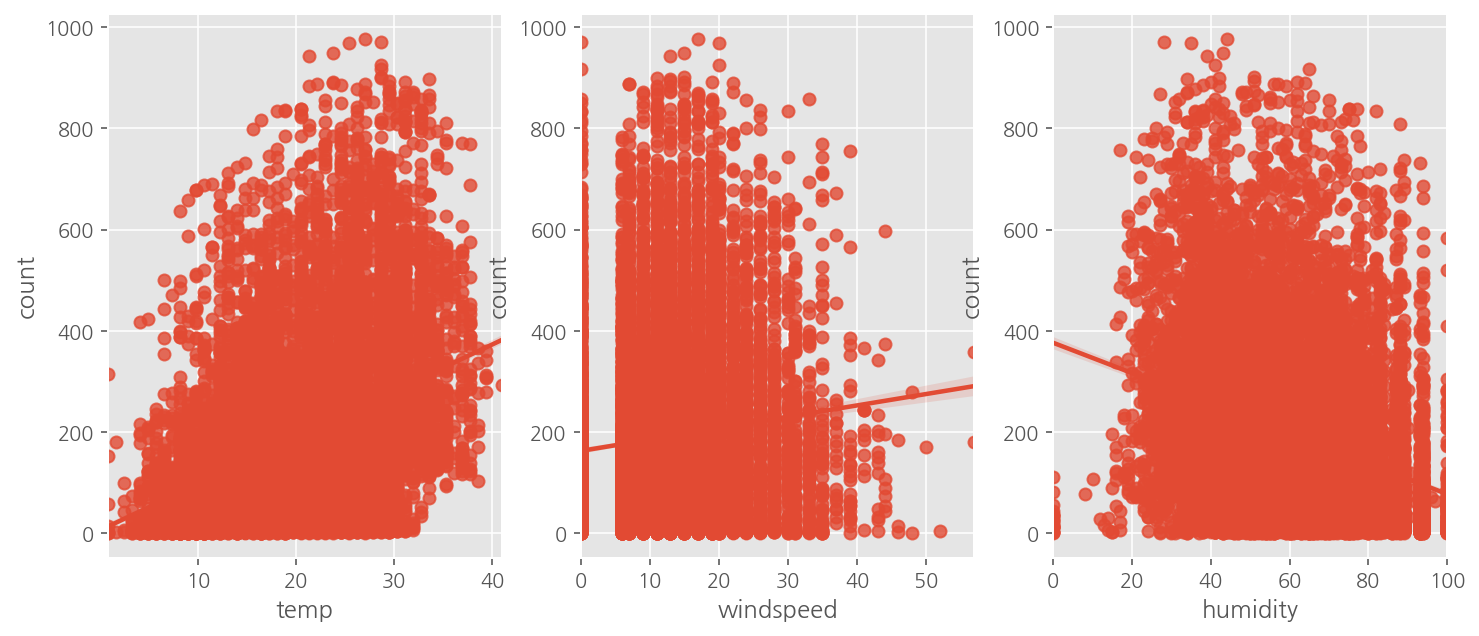

In [20]:
# 온도, 풍속, 습도에 따른 산점도 시각화 
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sns.regplot(x="temp", y="count", data=train,ax=ax1)
sns.regplot(x="windspeed", y="count", data=train,ax=ax2)
sns.regplot(x="humidity", y="count", data=train,ax=ax3)

풍속의 경우 0에 숫자가 몰림, 관측되지 않은 수치에 대해 0으로 기록된 것으로 추측

In [21]:
# 월별 데이터 모아서 확인
def concatenate_year_month(datetime) :
  return "{0}-{1}".format(datetime.year, datetime.month)

train["year_month"] = train["datetime"].apply(concatenate_year_month)

print(train.shape)
train[["datetime", 'year_month']].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


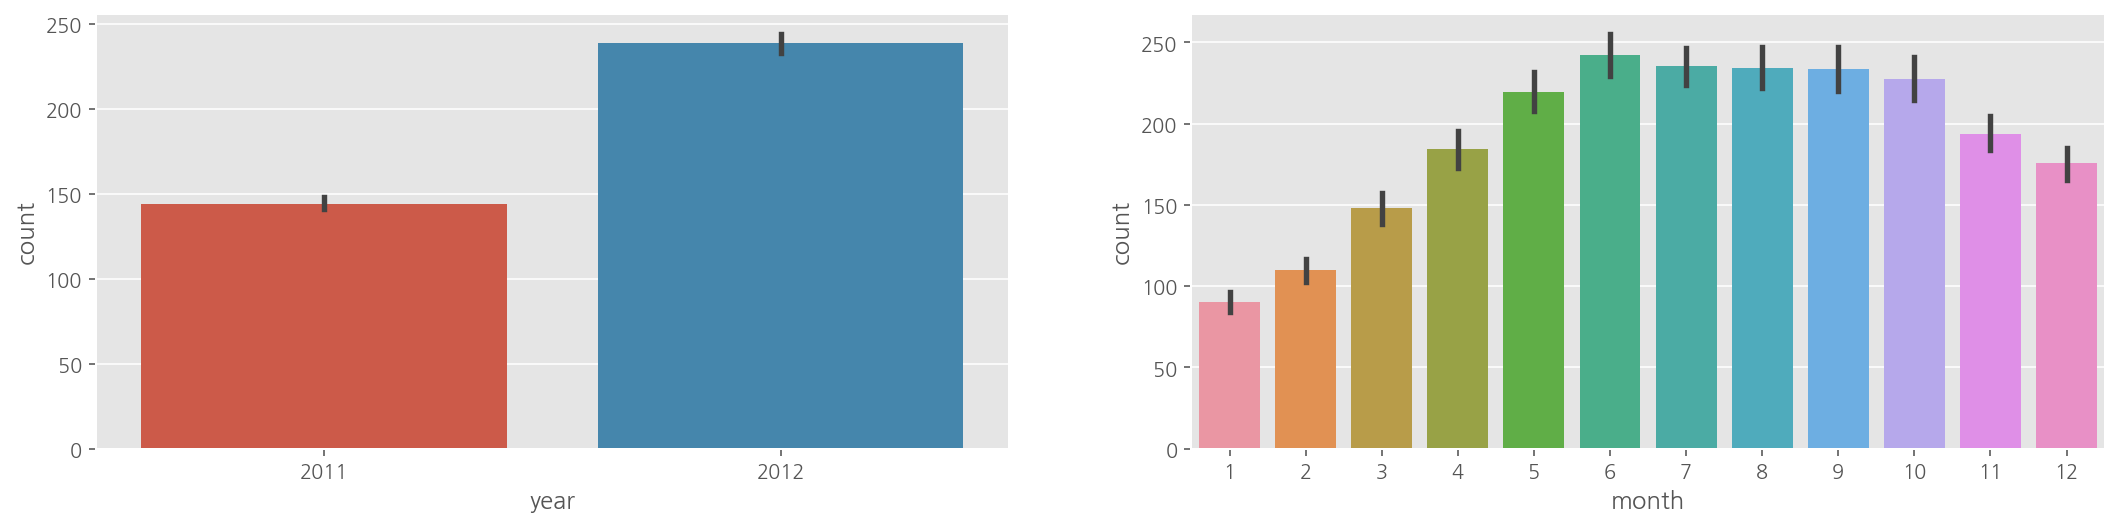

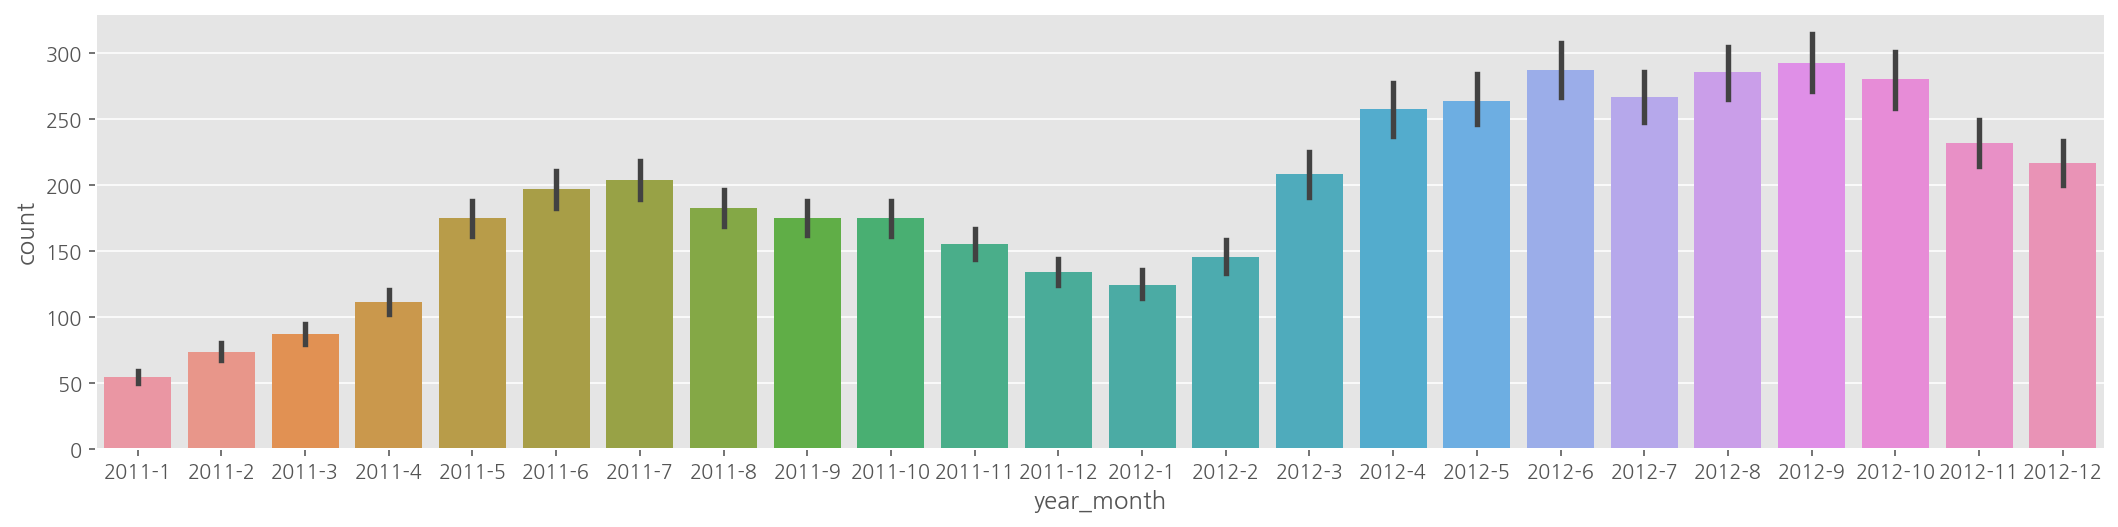

In [22]:
# 2011-2012 데이터 시각화
fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(18,4)

sns.barplot(data = train, x = "year", y = "count", ax = ax1)
sns.barplot(data = train, x = "month", y = "count", ax = ax2)

fig, ax3 = plt.subplots(nrows = 1, ncols = 1)
fig.set_size_inches(18,4)

sns.barplot(data = train, x = "year_month", y = "count", ax = ax3)

* 대여량의 양이 2011 < 2012
* 겨울 < 여름
* 2011년과 2012년 월별 데이터 확인 시 전체적으로 증가하는 추세

In [24]:
# Outliers데이터 제외
trainWithOutliers = train[np.abs(train["count"] - train["count"].mean()) <= (3*train["count"].std())]

print(train.shape)
print(trainWithOutliers.shape)

(10886, 20)
(10739, 20)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3486990121229776, 4.562423868087808, 0.9581176780909617))

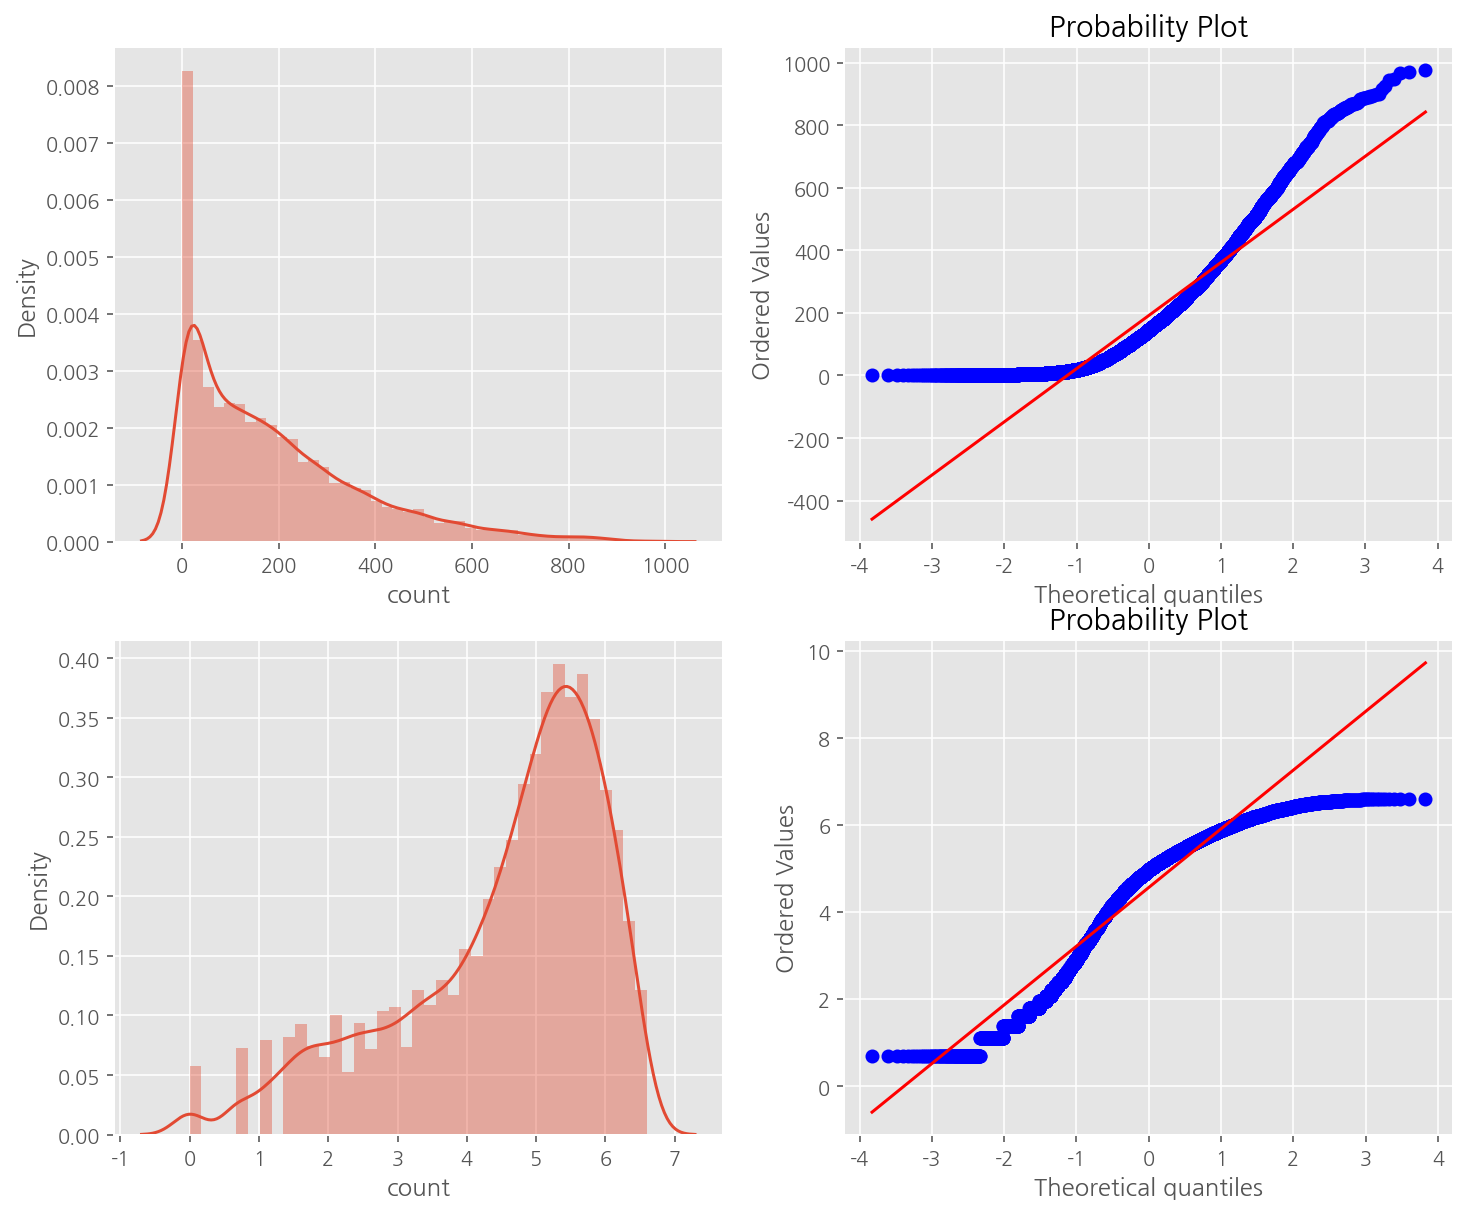

In [26]:
# count 값의 데이터 분포도 시각화
figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12,10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

count변수가 오른쪽으로 치우쳐있음. 대부분 기계학습은 종속변수가 normal이기에 정규분포를 갖는 것이 바람직. 대안으로 outlier data제거 + "count"변수에 로그를 씌워 병경해도 정규분포를 따르지 않으나 이전 그래프보다는 좀 더 자세히 표현함.